# Result data analyses from complex training
### Data fetched iether locally or from gdrive via oauth

In [1]:
# !rm -f *.png

## Compile Form in order to run the notebook

Forms provide an easy way to parameterize code. From a code cell, select Insert → Add form field. When you change the value in a form, the corresponding value in the code will change.

In [2]:
#@title Compile this form to run notebook:
import os
import warnings
warnings.filterwarnings("ignore", message="Numerical issues were encountered ")

#@markdown ---
#@markdown ##### Enter Root path:
root_path = "." # @param [".", /content/", "/content/drive/My Drive/Siren Deep Learning Analyses/results"]

#@markdown ---
#@markdown ##### Enter trial number:
train_no =  0  #@param {type:"integer", min:0, max:23, step:1}

#@markdown ---
#@markdown ##### Toggle checkbox to download resulting pictures:
download_pictures_checkbox = False #@param {type:"boolean"}

fetch_data_from_gdrive_checkbox = True #@param {type:"boolean"}

#@markdown ---
#@markdown ##### Enter dirname and image name:
dir_image = "/content/drive/My Drive/Siren Deep Learning Analyses/testsets/BSD68" # @param ["/content/", "/content/drive/My Drive/Siren Deep Learning Analyses/testsets/BSD68"]
image_name = "test068.png" #@param {type:"string"}

basedir_path_out_images = f"mixed_out_train_{train_no}" # @oaram ["/content", ".", out_train_{train_no}]

# if you get the shareable link, the link contains this id, replace the file_id below
file_id = ''

## Authentication phase

In [3]:
from utils.gdrive_auth import make_grdive_auth, fetch_data_from_gdrive

creds = make_grdive_auth()

Gdrive auth done.


## Setup

### Installations

In [4]:
# !pip install -q gwpy

In [5]:
# Clean /content from trash or old .png images
# !rm -f /content/*.png

### Imports

In [6]:
from datetime import datetime
# from google.colab import files

from pathlib import Path
from collections import namedtuple
from io import BytesIO
from pprint import pprint

# import psycopg2 as ps
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
# sns.set_theme(style="whitegrid")
import ipywidgets as widgets
# back end of ipywidgets
from IPython.display import display

import io
from googleapiclient.http import MediaIoBaseDownload
import zipfile

import collections
import itertools
import functools
import glob
import operator
import os
import re
import yaml
import numpy as np
import pandas as pd

from PIL import Image

# skimage
import skimage
import skimage.metrics as skmetrics
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from utils.make_graphics import (compute_graph_image_psnr_CR, graphics_bars_pointplot, \
  graphics_scatterplot, graphics_violinplot, graphics_boxplot, graphics_bars_mean_std, \
  graphics_pointplot_mean_std, graphics_regplot_mean_std)

from utils.works import calculate_several_jpeg_compression

In [7]:
dates_input = []
train_timestamps = []
trains_no = []
file_ids = []

### Setup output images full path

In [8]:
try:
    os.makedirs(basedir_path_out_images)
    print(f'Directory {basedir_path_out_images} created.')
except:
    print(f'Directory {basedir_path_out_images} already exists!')
    pass

Directory mixed_out_train_0 already exists!


In [9]:
from utils.configs import get_input_data_configs, get_output_graphics_configs

input_data_config = get_input_data_configs()

images_conf = get_output_graphics_configs(basedir_path_out_images)

config file read with success.
config file read with success.


### Functions

### Fetch Data

In [10]:
def adjust_date_format(date_input):
    return '-'.join([xx for xx in date_input.split('-')[::-1]])
date_inputs_tmp = list(map(adjust_date_format, input_data_config.dates_input))
print(date_inputs_tmp)

train_timestamps_tmp = [train_timestamp.replace('.', '-') for train_timestamp in input_data_config.train_timestamps]
print(train_timestamps_tmp)

trains_datetime = [os.path.join(date_input_tmp, train_timestamp_tmp)
                   for date_input_tmp, train_timestamp_tmp in zip(date_inputs_tmp, train_timestamps_tmp)]
print(trains_datetime)
print(input_data_config.trains_no)

['19-10-2020']
['1603096912-643607']
['19-10-2020\\1603096912-643607']
['6']


In [11]:
# print('Date train:', train_datetime)
path_history_trains = []
def adjust_trains_path(root_path, trains_no, trains_datetime = None):
    if root_path == "/content":
        path_history_trains = [os.path.join(
            root_path,
            f'result_comb_train_{train_no}.txt')
        for train_no in trains_no]
    elif root_path == ".":
        path_history_trains = [os.path.join(
            root_path,
            f'result_comb_train_{train_no}.txt')
        for train_no in trains_no]
    else:
        path_history_trains = [os.path.join(
            root_path,
            train_datetime,
            "train",
            f'result_comb_train_{train_no}.txt')
            for train_datetime, train_no in zip(trains_datetime, trains_no)]
    return path_history_trains

path_history_trains = adjust_trains_path(root_path, input_data_config.trains_no)
print("Path location:")
print(path_history_trains)

Path location:
['.\\result_comb_train_6.txt']


In [12]:
for path_history_train, file_id in zip(path_history_trains, input_data_config.file_ids):
    print('Trying fetching', path_history_train, '...')
    fetch_data_from_gdrive(creds, path_history_train, file_id, fetch_data_from_gdrive_checkbox)
    pass

Trying fetching .\result_comb_train_6.txt ...
Already exists: .\result_comb_train_6.txt


In [13]:
columns_df = ['#params', 'seed', 'hl', 'hf', 'mse', 'psnr', 'ssim', 'train_eta']

results_history_arr = None
for path_history_train in path_history_trains:
    print(path_history_train)
    if results_history_arr is None:
        results_history_arr = np.loadtxt(path_history_train)
        # print(results_history_arr)
    else:
        try:
            tmp_arr = np.loadtxt(path_history_train)
            # print(tmp_arr)
            results_history_arr = np.concatenate((results_history_arr, tmp_arr), axis = 0)
        except:
            tmp_arr = np.loadtxt(path_history_train)
            # print(tmp_arr)
            results_history_arr = np.concatenate((results_history_arr, [tmp_arr]), axis = 0)
            pass
        pass
    pass

results_history_df = pd.DataFrame(
    data = results_history_arr,
    columns = columns_df)

.\result_comb_train_6.txt


### Dataframe: brief description

In [14]:
results_history_df.head(5)

,#params,seed,hl,hf,mse,psnr,ssim,train_eta
0,81201.0,0.0,8.0,100.0,0.012225,25.148162,0.785677,922.854508
1,81201.0,42.0,8.0,100.0,0.010684,25.733180,0.808262,927.848073
2,81201.0,123.0,8.0,100.0,0.011767,25.313972,0.797508,924.310057
3,91301.0,0.0,9.0,100.0,0.010570,25.779829,0.810745,1032.205108
4,91301.0,42.0,9.0,100.0,0.010575,25.777809,0.807871,1033.405461


In [15]:
results_history_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   #params    7 non-null      float64
 1   seed       7 non-null      float64
 2   hl         7 non-null      float64
 3   hf         7 non-null      float64
 4   mse        7 non-null      float64
 5   psnr       7 non-null      float64
 6   ssim       7 non-null      float64
 7   train_eta  7 non-null      float64
dtypes: float64(8)
memory usage: 576.0 bytes


In [16]:
results_history_df.describe()

,#params,seed,hl,hf,mse,psnr,ssim,train_eta
count,7.000000,7.000000,7.000000,7.0,7.000000,7.000000,7.000000,7.000000
mean,88415.285714,47.142857,8.714286,100.0,0.011138,25.560507,0.802611,1002.830111
std,7634.882355,55.119351,0.755929,0.0,0.000726,0.279999,0.009504,82.443636
min,81201.000000,0.000000,8.000000,100.0,0.010465,25.148162,0.785677,922.854508
25%,81201.000000,0.000000,8.000000,100.0,0.010573,25.330670,0.797291,926.079065
50%,91301.000000,42.000000,9.000000,100.0,0.010684,25.733180,0.807871,1032.205108
75%,91301.000000,82.500000,9.000000,100.0,0.011722,25.778819,0.809503,1034.703395
max,101401.000000,123.000000,10.000000,100.0,0.012225,25.823231,0.811138,1143.186245


In [17]:
collections.Counter(results_history_df["hf"].values)

Counter({100.0: 7})

### Dataframe: in depth description

#### Scatter - Plot

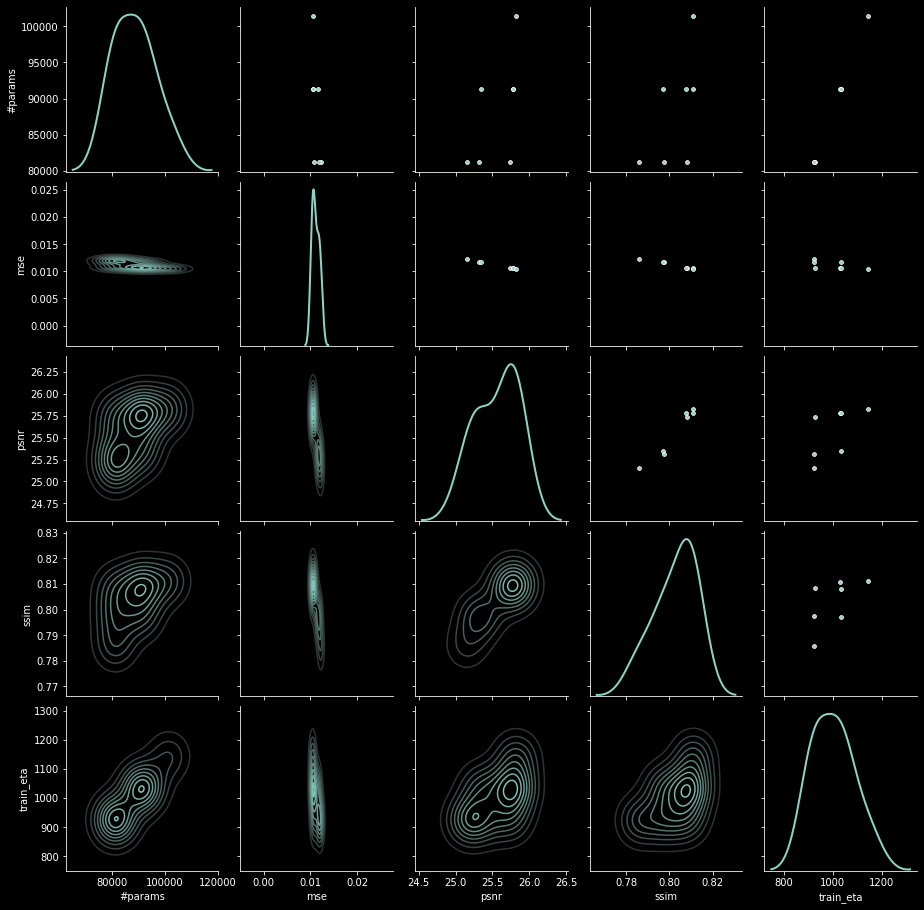

In [18]:
# sns.pairplot(results_history_df)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    try:
        g = sns.PairGrid(results_history_df.drop(['hf', 'hl', 'seed'], axis = 1), diag_sharey=False)
        g.map_upper(sns.scatterplot, s=15) # 
        g.map_lower(sns.kdeplot)
        g.map_diag(sns.kdeplot, lw=2)
        # plt.savefig(f'scatter_plot_train_no_{train_no}.png')
        plt.savefig(f'{images_conf.df_scatterplot}')
    except Exception as err:
        print(str(err))
        pass
    pass

#### Plots

In [19]:
# Compute Mean and Standard-Deviation for MSE and PSNR
# with respect to data grouped by means of'#params'-attribute
#  within dataframe object: 'results_history_df

results_history_df.groupby(by = ['#params'])[['mse', 'psnr', 'ssim', 'train_eta']]\
    .describe()[[
                ("mse", "mean"), ("mse", "std"),
                ("psnr", "mean"), ("psnr", "std"),
                ("ssim", "mean"), ("ssim", "std"),
                ("train_eta", "mean"), ("train_eta", "std")
                ]]

mse                 psnr                ssim            \
              mean       std       mean       std      mean       std   
#params                                                                 
81201.0   0.011559  0.000791  25.398438  0.301517  0.797149  0.011297   
91301.0   0.010941  0.000638  25.635002  0.249100  0.805230  0.007208   
101401.0  0.010465       NaN  25.823231       NaN  0.811138       NaN   

            train_eta            
                 mean       std  
#params                          
81201.0    925.004212  2.568134  
91301.0   1033.870633  1.940390  
101401.0  1143.186245       NaN

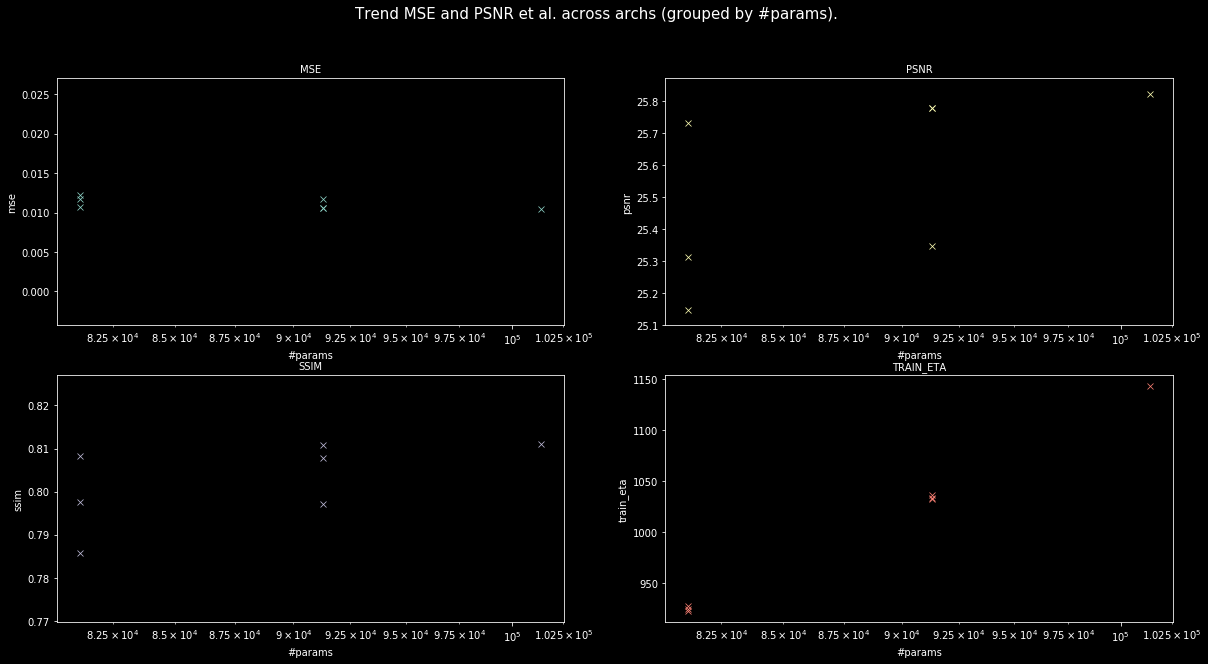

In [20]:
grid_shape = "(2, 2)" #@param ["(1, 4)", "(4, 1)", "(2, 2)"]
grid_shape = eval(grid_shape)

fig, axes = graphics_scatterplot(
    dataframe = results_history_df,
    y_axes = ("mse", "psnr", "ssim", "train_eta"),
    x_axis = "#params",
    grid_shape = grid_shape,
    figsize = (20, 10))
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"scatterplot_mse_psnr_et_al_vs_no_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.scatterplot}")

plt.show()

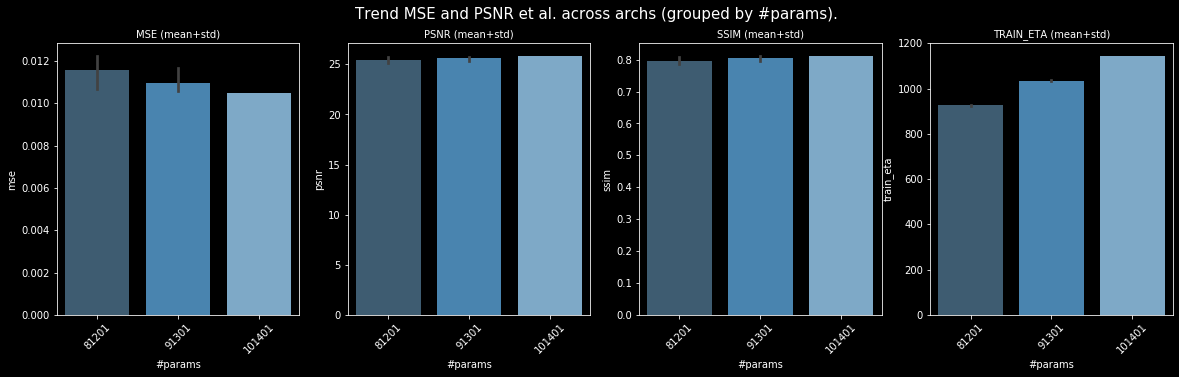

In [21]:
# %%capture
results_history_sorted_df = results_history_df.sort_values(by=['#params', 'hf', 'hl'])

grid_shape = "(1, 4)" #@param ["(1, 4)", "(4, 1)", "(2, 2)"]
grid_shape = eval(grid_shape)

fig, axes = graphics_bars_mean_std(
    dataframe = results_history_sorted_df,
    y_axes = ("mse", "psnr", "ssim", "train_eta"),
    x_axis = "#params",
    grid_shape = grid_shape,
    figsize = (20, 5))
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"bar_plot_mse_psnr_et_al_grouped_by_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.barplot}")
plt.show()

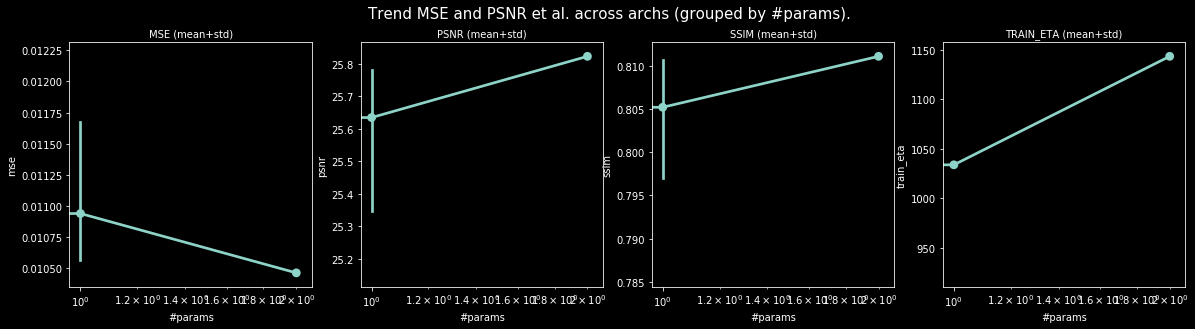

In [22]:
results_history_sorted_df = results_history_df.sort_values(by=['#params', 'hf', 'hl'])

grid_shape = "(1, 4)" #@para m ["(1, 4)", "(4, 1)", "(2, 2)"]
grid_shape = eval(grid_shape)

fig, axes = graphics_pointplot_mean_std(
    dataframe = results_history_sorted_df,
    y_axes = ("mse", "psnr", "ssim", "train_eta"),
    x_axis = "#params",
    grid_shape = grid_shape, 
    figsize = (20, 5))
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"pointplot_mse_psnr_et_al_grouped_by_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.pointplot}")
plt.subplots_adjust(bottom = 0.2)
plt.show()

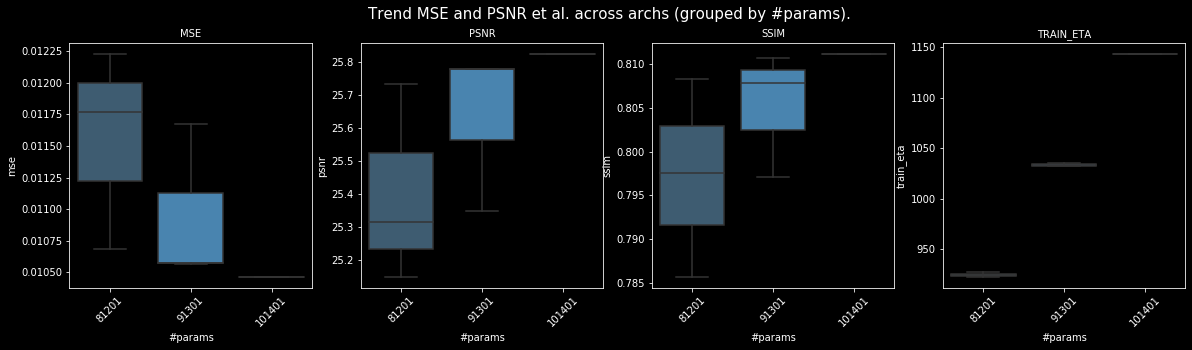

In [23]:
results_history_sorted_df = results_history_df.sort_values(by=['#params', 'hf', 'hl'])

grid_shape = "(1, 4)" #@param ["(1, 4)", "(4, 1)", "(2, 2)"]
grid_shape = eval(grid_shape)

fig, axes = graphics_boxplot(
    dataframe = results_history_sorted_df,
    y_axes = ("mse", "psnr", "ssim", "train_eta"),
    x_axis = "#params",
    grid_shape = grid_shape,
    figsize = (20, 5))
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"boxplot_mse_psnr_et_al_grouped_by_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.boxplot}")
plt.subplots_adjust(bottom = 0.2)
plt.show()

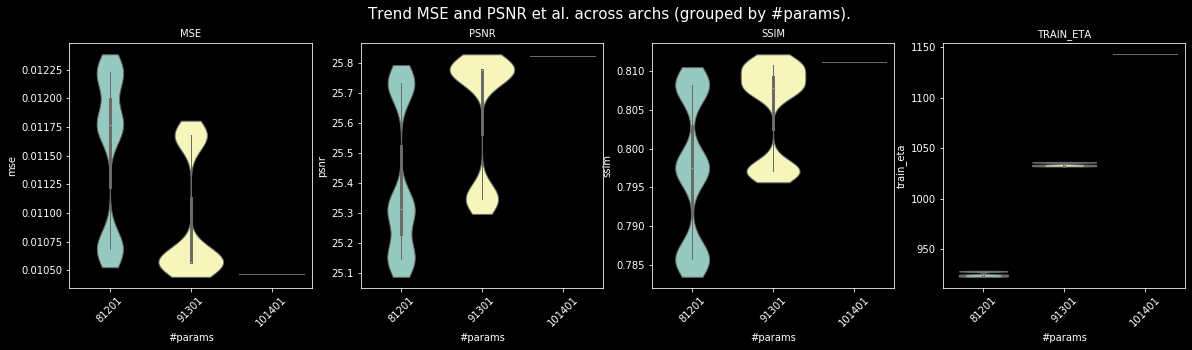

In [24]:
results_history_sorted_df = results_history_df.sort_values(by=['#params', 'hf', 'hl'])

grid_shape = "(1, 4)" #@param ["(1, 4)", "(4, 1)", "(2, 2)"]
grid_shape = eval(grid_shape)

fig, axes = None, None
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig, axes = graphics_violinplot(
        dataframe = results_history_sorted_df,
        y_axes = ("mse", "psnr", "ssim", "train_eta"),
        x_axis = "#params",
        grid_shape = grid_shape,
        figsize = (20, 5))
    pass
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"violinplot_mse_psnr_et_al_grouped_by_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.violinplot}")
plt.subplots_adjust(bottom = 0.2)
plt.show()

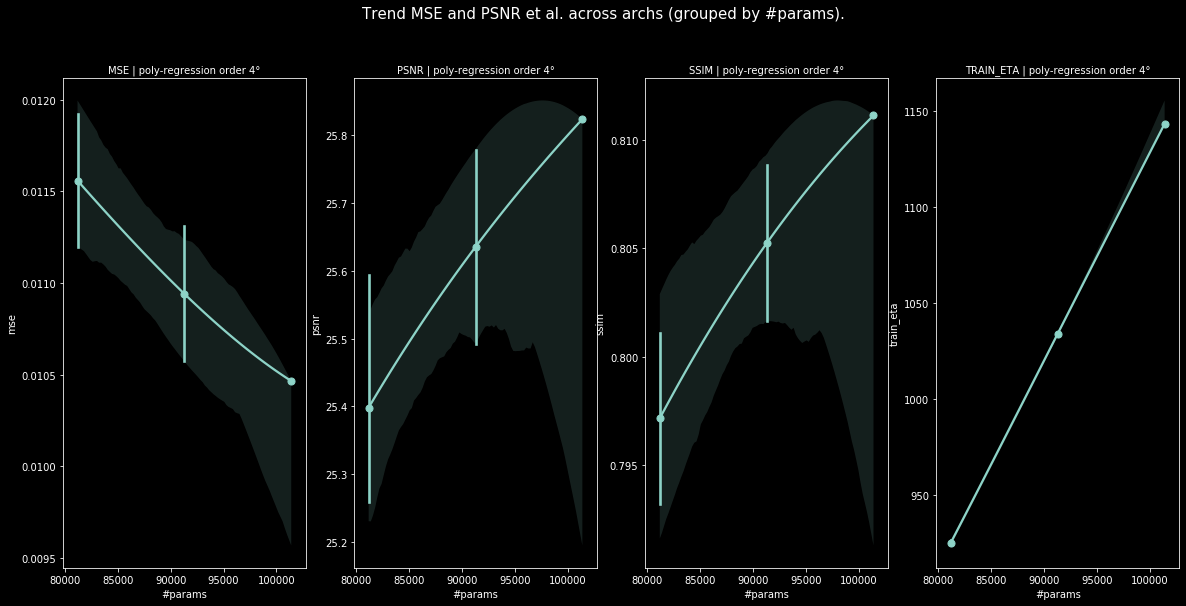

In [25]:
results_history_sorted_df = results_history_df.sort_values(by=['#params', 'hf', 'hl'])

grid_shape = "(1, 4)" #@param ["(1, 4)", "(4, 1)", "(2, 2)"]
grid_shape = eval(grid_shape)

fig, axes = None, None
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig, axes = graphics_regplot_mean_std(
        dataframe = results_history_sorted_df,
        y_axes = ("mse", "psnr", "ssim", "train_eta"),
        x_axis = "#params",
        grid_shape = grid_shape,
        figsize = (20, 10))
    pass
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"regplot_mse_psnr_et_al_grouped_by_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.regplot}")
plt.subplots_adjust(bottom = 0.2)
plt.show()

### Summary Graph

In [ ]:
fig, axes = None, None
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig, axes = graphics_bars_pointplot(
        dataframe = results_history_sorted_df,
        y_axes = ("mse", "psnr", "ssim", "train_eta"),
        x_axis = "#params",
        grid_shape = (6, 4),
        figsize = (20, 20), palette="Blues_d",
        show_fig = False,
        title = 'Complex Plot')
    pass
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"complex_mse_psnr_et_al_grouped_by_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.complexplot}")
plt.subplots_adjust(bottom = 0.2)
# plt.tight_layout()
plt.show()

### Download files

In [ ]:
print(f"Pictures ({len(list(Path(basedir_path_out_images).glob('*.png')))}):")
for path in Path(basedir_path_out_images).glob('*.png'):
    target_file = os.path.join(basedir_path_out_images, path.name)
    print(f"{target_file}")
    # if download_pictures_checkbox: files.download(target_file)
    pass

### Compare obtained results between JPEG and Siren

In [ ]:
# Load target image.
image_file_path = 'test068.png'
im = Image.open(f'{image_file_path}')
print('Image size:', im.size)
im

In [ ]:
# Test how to manually crop image from its center.
width, height = im.size 

left = width - height
top = 0
right = width
bottom = height

im.crop((left, top, right, bottom))

In [ ]:
# Array of qualities to be tested in compression.
qualities_arr = np.arange(1, 99+1, dtype = np.int)

In [ ]:
# Run several trials for JPEG compression.

result_tuples, failure_qualities = \
  calculate_several_jpeg_compression(im, qualities_arr, left, top, right, bottom)

In [ ]:
# Show calculated PSNR vs. # Bits.

# Prepare Data.
# x = np.arange(0, len(result_tuples), dtype=np.int)
x = np.array(list(map(lambda item: getattr(item, "file_size_bits"), result_tuples)))
y = np.array(list(map(lambda item: getattr(item, "psnr"), result_tuples)))

# Show plot.
fig = plt.figure()
plt.scatter(x, y, marker = 'x', color = sns.color_palette()[1], label = 'jpeg')
# plt.xscale('log')
plt.ylabel('PSNR')
plt.xlabel('# Bits')
plt.legend()
plt.title('PSNR vs. # Bits')
plt.show()

In [ ]:
# Show calculated CR vs. # BPP.

# x = np.arange(0, len(result_tuples), dtype=np.int)
x = np.array(list(map(lambda item: getattr(item, "bpp"), result_tuples)))
y = np.array(list(map(lambda item: getattr(item, "CR"), result_tuples)))

fig = plt.figure()
plt.scatter(x, y, marker = 'x', color = sns.color_palette()[1], label = 'jpeg')
# plt.xscale('log')
plt.ylabel('CR')
plt.xlabel('BPP')
plt.legend()
plt.title('CR vs. BPP')
plt.show()

In [ ]:
# Show calculated CR vs. # Bits.

# Prepare data.
# x = np.arange(0, len(result_tuples), dtype=np.int)
x = np.array(list(map(lambda item: getattr(item, "file_size_bits"), result_tuples)))
y = np.array(list(map(lambda item: getattr(item, "CR"), result_tuples)))

fig = plt.figure()
plt.scatter(x, y, marker = 'x', color = sns.color_palette()[1], label = 'jpeg')
# plt.xscale('log')
plt.ylabel('CR')
plt.xlabel('# Bits')
plt.legend()
plt.title('CR vs. # Bits')
plt.show()

In [ ]:
# Show calculated PSNR vs. Bits.

# Prepare Data
# x = np.arange(0, len(result_tuples), dtype=np.int)
x = np.array(list(map(lambda item: getattr(item, "bpp"), result_tuples)))
y = np.array(list(map(lambda item: getattr(item, "psnr"), result_tuples)))

# Show Plot
fig = plt.figure()
plt.scatter(x, y, marker = 'x', color = sns.color_palette()[1], label = 'jpeg')
# plt.xscale('log')
plt.ylabel('PSNR')
plt.xlabel('BPP')
plt.legend()
plt.title('PSNR vs. BPP')
plt.show()

In [ ]:
# Prepare pairs of attributes to be represented
# one against the other via scatter plot.
x_axes = "bpp;file_size_bits".split(";")
y_axes = "psnr;CR".split(";")

pairs_axes = list(itertools.product(x_axes, y_axes))

# Settle figure grid.
axes_list = None
fig, axes = plt.subplots(len(x_axes), len(y_axes), figsize=(20, 10))
fig.suptitle(f'JPEG', fontsize=15)
try:
    axes_list = functools.reduce(operator.iconcat, axes, [])
except:
    axes_list = axes
    pass

# Compute graph.
for ii, (ax, pair_axes) in enumerate(zip(axes_list, pairs_axes)):
    # Prepare data.
    x_axis, y_axis = pair_axes[0], pair_axes[1]
    x = np.array(list(map(lambda item: getattr(item, f"{x_axis}"), result_tuples)))
    y = np.array(list(map(lambda item: getattr(item, f"{y_axis}"), result_tuples)))
    # Create Chart.
    ax.scatter(x, y, marker = 'x', color = sns.color_palette()[ii], label = 'jpeg')
    # ax.set_xscale('symlog')
    # ax.set_yscale('symlog')
    ax.set_ylabel(f'{y_axis}')
    ax.set_xlabel(f'{x_axis}')
    ax.legend()
    ax.set_title(f'{y_axis.upper()} vs. {x_axis.upper()}')
    pass
# Show result.
plt.savefig('complex_plot_jpge_res.png')
plt.show()

In [ ]:
x_axes = "bpp;file_size_bits".split(";")
y_axes = "psnr;CR".split(";")

fig, axes = compute_graph_image_psnr_CR(
    data_tuples = result_tuples,
    x_axes = x_axes,
    y_axes = y_axes,
    subject = 'jpeg',
    colors = sns.color_palette())
fig.suptitle(f'JPEG', fontsize=15)
# plt.savefig('complex_plot_jpge_res.png')
plt.show()

In [ ]:
# Compare PSNR values between JPEG and Siren, by means of scatterplot.
fig = plt.figure()

# Siren results
# plt.scatter(x = np.arange(len(results_history_sorted_df['psnr'].values)), y = results_history_sorted_df['psnr'].values, marker = 'x', color = sns.color_palette()[0], label = 'siren output')
plt.scatter(x = results_history_sorted_df['#params'].values * 32,
    y = results_history_sorted_df['psnr'].values,
    marker = 'x',
    color = sns.color_palette()[0],
    label = 'siren')

# Jpeg results
x = np.array(list(map(lambda item: getattr(item, "file_size_bits"), result_tuples)))
y = np.array(list(map(lambda item: getattr(item, "psnr"), result_tuples)))
plt.scatter(x, y, marker = 'x', color = sns.color_palette()[1], label = 'jpeg')

# plt.xscale('log')
plt.ylabel('PSNR')
plt.xlabel('# Bits')
plt.legend()
plt.title('PSNR vs. # Bits')
plt.show()

## References

- Wiki references:
 - [Image Compression](https://en.m.wikipedia.org/wiki/Image_compression)
 - [Bit Rate](https://en.wikipedia.org/wiki/Bit_rate)

- Generic references:
 - [FORM](https://colab.research.google.com/notebooks/forms.ipynb#scrollTo=3jKM6GfzlgpS)
 - [jupiter - themese](https://stackoverflow.com/questions/46510192/change-the-theme-in-jupyter-notebook)